# Statistical Path Planning

## Introduction

Multi-agent path planning (MAPP) is the task of finding efficient, collision-free paths for multiple agents within a shared environment. This problem arises in various fields, from robotics and autonomous vehicles to video games and disaster response. One common approach to solving MAPP is conflict-based search (CBS), which is an optimal algorithm that divides the planning problem into smaller subproblems and solves them recursively.

However, CBS requires complete knowledge of the environment prior to planning, which can be problematic in dynamic or unpredictable scenarios. To address this limitation, we train a lightweight statistical model to mimic the behavior of CBS by predicting the actions agents will take given their local field of views (FOVs). Unlike traditioanl CBS, our approach is decentralized and requires only partial knowledge of the environment. 

In this notebook, we will walk through the implementation and evaluation of our approach. We start by loading the CBS-5 dataset, containing millions of CBS actions made within different contexts. We then train and evaluate three models on the dataset, including a logistic regression model, a multi-layer perceptron (MLP), and a small convolutional neural network (CNN).

## Dependencies

In [3]:
!pip install -q tensorflow keras scikit-learn pillow

## Dataset


The CBS-5 dataset contains over 5 million actions taken by CBS agents in a variety of environments and scenarios. Each example maps an agent's local field of view (FOV) to one of five actions (`Stay`, `North`, `East`, `South`, `West` and). The FOV is a 7x7 binary image with three channels:

- `State`: encodes the relative position of agents within the FOV.
- `Goal`: encodes the relative position of an agent's goal within the FOV. Clipped to the FOV boundary when out of range.
- `Map`: encodes the relative position of obstacles within the FOV.

The dataset is stored in a bespoke compressed format, so we'll first write a small function to decompress it:

In [4]:
import gzip
import numpy as np


def load_chunk(path: str, shape: tuple = tuple()) -> np.array:
    """
    Decompresses a CBS-5 chunk and loads it into memory
    as a NumPy array.

    Parameters
    ----------

    path: str

        The location of CBS-5 chunk.

    shape: tuple = (,)
    
        The shape of the chunk array.

    Returns
    -------

    chunk: np.array

        The decompressed chunk.
    """
    
    with gzip.GzipFile(path) as file:
        
        chunk = np.array(list(file.read()))        
        chunk = chunk.reshape((-1, *shape))
        chunk = chunk.astype(float)
        
        return chunk

Now let's download and decompress the two chunks from CBS-5 to use as our train and test datasets.

In [5]:
!git clone -q https://github.com/oelin/cbs-5

In [6]:
labels_train = load_chunk('./cbs-5/v0/labels/labels0.gz')
inputs_train = load_chunk('./cbs-5/v0/inputs/inputs0.gz', shape=(7, 7, 3))
labels_test = load_chunk('./cbs-5/v1/labels/labels0.gz')
inputs_test = load_chunk('./cbs-5/v1/inputs/inputs0.gz', shape=(7, 7, 3))

Let's see how many examples are in each chunk.

In [7]:
labels_train.shape, labels_test.shape

((1130725,), (1131310,))

Nice, there's roughly 1.1 million examples per chunk. Not only do we have have a large number of examples, but the train-test split it ~50%. This will futher mitigate risks of overfitting during training.

Let's take a look at a single example from the train dataset.

In [8]:
from PIL import Image


def show_fov_channel(channel: np.array) -> Image:
    """
    Displays a FOV channel as an image.
    """
    
    channel = channel * 255
    channel = channel.astype('uint8')
    channel = channel.repeat(20, 0).repeat(20, 1)
    image = Image.fromarray(channel)
    
    return image

In [9]:
# Separate FOV channels (State, Goal, Map).

example = inputs_train[0]
example_state = example[:, :, 2]
example_goal = example[:, :, 1]
example_map = example[:, :, 0]

State:


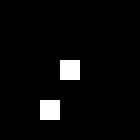

In [10]:
print('State:')
show_fov_channel(example_state)

Goal:


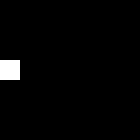

In [11]:
print('Goal:')
show_fov_channel(example_goal)

Map:


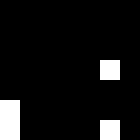

In [12]:
print('Map:')
show_fov_channel(example_map)

In this moment, the agent's target it to the *left* and several obstacles sit to right and bottom left of the agent. We would expect the action taken in this sitution to be `West`. Let's see if we're correct.

In [14]:
print(f'Action: {labels_train[0]}')

Action: 4.0


Action 4 corresponds to `West`!

One last thing we need to do is "one-hot" encode the lables, as neural networks cannot handle categorical variables directly. We can use Scikit-learn's `OneHotEncoder` preprocessor class for this.

In [15]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)

y_train = one_hot_encoder.fit_transform(labels_train.reshape(-1, 1))
y_test = one_hot_encoder.fit_transform(labels_test.reshape(-1, 1))

X_train, X_test = inputs_train, inputs_test

In [16]:
y_train[0]

array([0., 0., 0., 0., 1.])

## Training

Now we're ready to start training some models. As mentioned in the introduction, we'll be training a logistic regression model, an MLP and a CNN. It's often best to start with the simplest model and increase complexity if needed. In this case, logistic regression is the simplest with only 735 parameters (7x7x3x4). We'll Keras's `Sequential` function to construct the model.

In [21]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 147)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 740       
                                                                 
Total params: 740
Trainable params: 740
Non-trainable params: 0
_________________________________________________________________


Now let's compile and optimize the model.

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2)

Epoch 1/2
35336/35336 [==============================] - 99s 3ms/step - loss: 0.1746 - accuracy: 0.9463 - val_loss: 0.1084 - val_accuracy: 0.9577
Epoch 2/2
35336/35336 [==============================] - 93s 3ms/step - loss: 0.1073 - accuracy: 0.9580 - val_loss: 0.1069 - val_accuracy: 0.9578


Remarkably, after only two epochs, this simple linear model is able to achieve above 95% accuracy. This means that in 95% of contexts, the model is able to predict which action a CBS agent will take. Note that a randomly guessing model would achieve only 20%. Additionally, we see that the model performs equally well (sometimes slightly better) on unseen examples, showing that it has not overfit and is likely to generalize well. 

Next, we consider an MLP architecture. This is virutally identical however features additional hidden layers. We choose to use three hidden layers.

In [24]:
model2 = Sequential()
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(5, activation='softmax'))

In [26]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 147)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               37888     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 5)                 325       
                                                                 
Total params: 79,365
Trainable params: 79,365
Non-trainable params: 0
_________________________________________________________________


In [25]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2)

Epoch 1/2
35336/35336 [==============================] - 165s 5ms/step - loss: 0.0961 - accuracy: 0.9630 - val_loss: 0.0842 - val_accuracy: 0.9674
Epoch 2/2
35336/35336 [==============================] - 163s 5ms/step - loss: 0.0813 - accuracy: 0.9686 - val_loss: 0.0823 - val_accuracy: 0.9683


This model performs slightly better however is considerably larger with 79 thousand parameters instead of 740. In this case, the improvement to performance is probably not worth the additional compute.

Finally, we test a small CNN model.

In [31]:
model3 = Sequential()

# Feature extraction.

model3.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=X_train[0].shape))
model3.add(Conv2D(32, kernel_size=3, activation='relu'))
model3.add(Flatten())

# Prediction.

model3.add(Dense(5, activation='softmax'))

In [32]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 5, 5, 64)          1792      
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 3, 32)          18464     
                                                                 
 flatten_4 (Flatten)         (None, 288)               0         
                                                                 
 dense_8 (Dense)             (None, 5)                 1445      
                                                                 
Total params: 21,701
Trainable params: 21,701
Non-trainable params: 0
_________________________________________________________________


In [33]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4)

Epoch 1/4
35336/35336 [==============================] - 197s 6ms/step - loss: 0.0944 - accuracy: 0.9639 - val_loss: 0.0818 - val_accuracy: 0.9684
Epoch 2/4
35331/35336 [============================>.] - ETA: 0s - loss: 0.0813 - accuracy: 0.9683

KeyboardInterrupt: ignored

As with the MLP, we see marginal improvement from the baseline logistic regression model, however this improvement comes at the cost of additional overhead. The fact that more complex models do not significantly improve performance suggests there is in a sense *nothing more to learn* from an agent's FOV. To improve predictive accuracy further, we would likely need to consider additional factors, such as inter-agent communication. 

Let's save all three models.

In [37]:
model.save('statistical_path_planning_logistic_regression.h5')
model2.save('statistical_path_planning_mlp.h5')
model3.save('statistical_path_planning_cnn.h5')

## Visualizations

To aid in model explainability, we now use a simple weight visualization technique for the 740-parameter logistic regression model.

In [55]:
def normalize(data: np.array) -> np.array:
    """
    Normalize a NumPy array.
    """

    return (data - np.min(data)) / (np.max(data) - np.min(data))


def visualize_fov_weights(channel: int = 0, action: int = 0) -> Image:
    """
    Visualizes the weights relating a particular FOV channel to an 
    agent action.
    """

    weights = model.layers[1].weights[0] # All model weights.
    weights = weights.numpy().T[action]
    weights = weights.reshape(7, 7, 3).T[channel] 
    weights = normalize(weights)

    # Convert the weights to an image where light pixels indicate a large 
    # positive weight and dark pixels indicate a large negative weight.

    weights = (weights * 255).astype('uint8')
    weights = weights.repeat(30, 0).repeat(30, 1)
    image = Image.fromarray(weights)

    return image

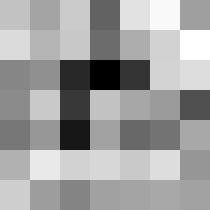

In [56]:
visualize_fov_weights(0, 0)

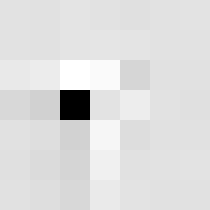

In [57]:
visualize_fov_weights(0, 1)

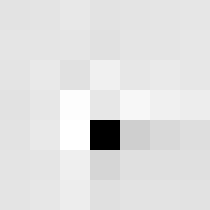

In [58]:
visualize_fov_weights(0, 2)

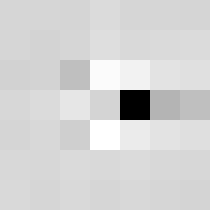

In [59]:
visualize_fov_weights(0, 3)

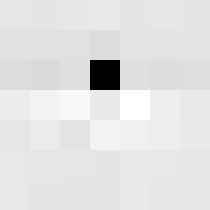

In [60]:
visualize_fov_weights(0, 4)

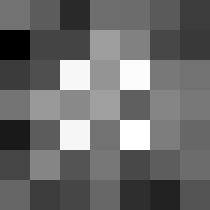

In [66]:
visualize_fov_weights(2, 0)

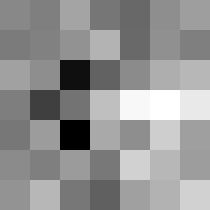

In [67]:
visualize_fov_weights(2, 1)

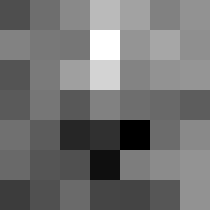

In [68]:
visualize_fov_weights(2, 2)

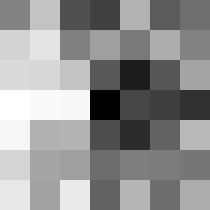

In [69]:
visualize_fov_weights(2, 3)

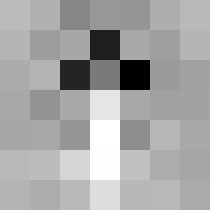

In [70]:
visualize_fov_weights(2, 4)